In [45]:
# third party imports
import pandas as pd
# standard library imports
import os
import sys
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(os.path.abspath(parent_path))
# local imports
from constants import COLUMNS_WE_NEED
from utils.transform_data import transform_reply_to,combine_message_and_reply
from utils.clean_data import clean_text
from utils.helpers import is_it_talk_about_hajez, is_it_give_information,is_question_arabic

In [46]:
data = pd.read_csv('../data/raw.csv') # read the data

In [47]:
data = data[COLUMNS_WE_NEED] # filter the columns we need from the data

# Null handling 

In [48]:
data.isna().sum() # check for null values

id              0
date            0
message      6665
reply_to    63934
dtype: int64

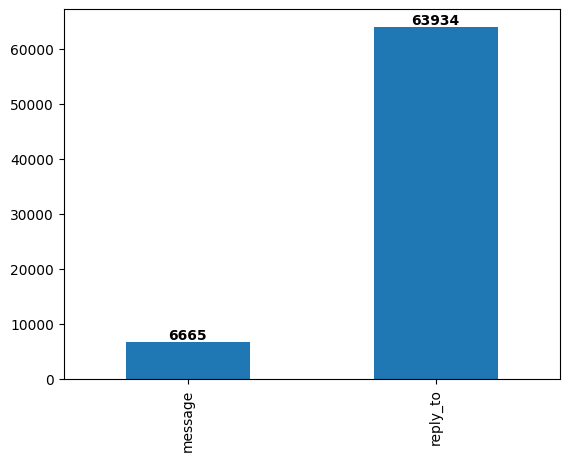

In [49]:
null_count = data.isna().sum()
# delete the zero values
null_count = null_count[null_count != 0]
# plot null_count as a bar chart and print the real values inside the bars
from matplotlib import pyplot as plt
null_count.plot(kind='bar')
for index, value in enumerate(null_count):
    plt.text(index, value, str(value), color='black', fontweight='bold', ha='center', va='bottom') # not in the center
plt.show()


In [50]:
# drop the rows with null values in the 'message' column
data = data.dropna(subset=['message'])

In [51]:
data['reply_text'] = data.apply(transform_reply_to,args=(data,), axis=1) # transform the reply_to column to reply_text column
data = data.drop(columns=['reply_to']) # drop reply_to column because we don't need it anymore

In [52]:
data[data['reply_text']!=""].head(1)

,id,date,message,reply_text
10,428928,2023-03-17 11:41:19+00:00,سالكة,حوارة كيف والحاجز


## Draw wordCloud to see the most frequent words in the dataset 

In [18]:
# all_text = ' '.join(data['message'].apply(str).tolist())
# draw_word_cloud(all_text, 'message_word_cloud')

## Data cleaning 
* Remove phone numbers
* Remove non-Arabic characters

In [53]:
data['message_clean_text'] = data['message'].apply(clean_text)
data['reply_clean_text'] = data['reply_text'].apply(clean_text)

## Message Classification 
* Stetment
* Question


In [54]:
data['message_type'] = data['message_clean_text'].apply(lambda x : 'question' if is_question_arabic(x) else 'statement')
data['reply_type'] = data['reply_clean_text'].apply(lambda x : 'question' if is_question_arabic(x) else 'statement')


In [55]:
data[data['message_type']=='statement'].sample(10)[["message_clean_text","message_type","reply_clean_text","reply_type"]]

,message_clean_text,message_type,reply_clean_text,reply_type
5174,مغلق,statement,زعترة شو وضعها,question
60196,حركه السير المعتاده بيوم خميس,statement,حواره شو وضضعها,question
39562,وحوارة,statement,,statement
14084,يا شباب للي طالع على رام الله من طريق تل ل بورين ل حوارة بعد الحاجز,statement,,statement
53431,مرقنا عادي,statement,,statement
7243,من ارئيل لزعترة سالكة تمام جهة حوارة مسكر والباقي سالك,statement,,statement
3036,الله يسمع منك,statement,في قتلا شباب,statement
4272,استشهد,statement,شكلهم مسكوه,statement
48846,زعتره سالكه الازمه على دوار بيتا,statement,,statement
59475,الله يستر,statement,,statement


# Combine the message with the reply if its there 
* take only the full massage that talk about any Hajez and give information about it , not just asking about it

In [56]:
data['full_text'] = data.apply(combine_message_and_reply, axis=1)

In [41]:
pd.set_option('display.max_colwidth', None)
data.sample(10)[["message_clean_text","message_type","reply_clean_text","reply_type","full_text"]]

,message_clean_text,message_type,reply_clean_text,reply_type,full_text
64892,صباح الخير ال عصيرة سالك تمام,statement,,statement,
51164,صباح الخير,statement,,statement,
57142,حاجز حوارة سالك,statement,,statement,حاجز حوارة سالك
80637,للداخل ؟,question,سالك صرة للخارج,statement,
61638,الله بعين,statement,لانه الناس مروحة مش طالعه وما حدا مارق لهيك ما حدا مجاوب ما حدا اعطا تحديثات جديدة,statement,
82216,حوارة سالك مع تفتيش ل السيارات الي فيها شباب خاصة,statement,,statement,حوارة سالك مع تفتيش ل السيارات الي فيها شباب خاصة
58554,المربعة حاجز,statement,,statement,المربعة حاجز
41035,صره سالك بالاتجاهين,statement,,statement,صره سالك بالاتجاهين
67126,شى وضع حوارة وزعترة يا شباب ؟,question,,statement,
47787,شو وضع دير شرف؟,question,,statement,


In [42]:
data

,id,date,message,reply_text,message_clean_text,reply_clean_text,message_type,reply_type,full_text
0,428911,2023-03-17 11:04:46+00:00,الدي سي اوه عليه مشاكل ؟؟,,الدي سي اوه عليه مشاكل ؟؟,,question,statement,
1,428913,2023-03-17 11:12:41+00:00,شباب طريق جنين قلقيلة شو وضعها,,شباب طريق جنين قلقيلة شو وضعها,,question,statement,
2,428918,2023-03-17 11:20:54+00:00,حومش و شافي شمرون شو وضعهم,,حومش و شافي شمرون شو وضعهم,,question,statement,
3,428920,2023-03-17 11:24:52+00:00,صرة للداخل نابلس؟,,صرة للداخل نابلس؟,,question,statement,
4,428922,2023-03-17 11:28:31+00:00,من رام الله لنابلس,,من رام الله لنابلس,,statement,statement,
...,...,...,...,...,...,...,...,...,...
86374,508173,2023-04-03 20:05:09+00:00,ماشي,كيف حاجز حوارة حالياً,ماشي,كيف حاجز حوارة حالياً,statement,question,كيف حاجز حوارة حالياً|||ماشي
86375,508174,2023-04-03 20:05:21+00:00,سالك,حوارة للخارج كيف,سالك,حوارة للخارج كيف,statement,question,حوارة للخارج كيف|||سالك
86376,508175,2023-04-03 20:07:08+00:00,من نابلس للفندق كيف الوضع,,من نابلس للفندق كيف الوضع,,question,statement,
86377,508176,2023-04-03 20:07:23+00:00,دير شرف للخارج كيف ؟,,دير شرف للخارج كيف ؟,,question,statement,


In [58]:
data[data['full_text']!=''].shape

(23261, 9)

In [57]:
# # filter the data to get only the rows that have full_text
data = data[data['full_text']!='']


### save the data in a csv file 

In [44]:
data.to_csv('../data/cleaned_transformed_data.csv', index=False)